Notebook to determine the noise level from a TS values

In [1]:
import csv
import os
from datetime import timedelta
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import matplotlib.dates as mdates
import warnings

%matplotlib inline

In [2]:
sns.set_theme(style="whitegrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

warnings.simplefilter("ignore")

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16



## Analysis
In Echoview, Single Echo Detection + 0.07m mask on TS data, only noise left.

Export TS (nominal frequency) of noise.

In [4]:
#Read file
fname = 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/Noise_TS.csv'


time_cols = [0,4,5]
noise_TS = pd.read_csv(fname,header=None, skiprows=1,index_col = 0)#, usecols=np.append(time_cols,TS_cols))


### Make datetime array

In [5]:
times=[]
for ind in range(0,len(noise_TS)):
    times = np.append(times, datetime.strptime('%s.%s' %(noise_TS[4].values[ind],int(noise_TS[5].values[ind])), '%H:%M:%S.%f'))


### Organize columns

In [6]:
start = 15
n_bins = np.shape(noise_TS)[1]-start

TS_cols = np.arange(start,n_bins+start)

### Read range

In [ ]:
depth = pd.read_csv(fname,header=None, skiprows=1, usecols=[8,9], nrows=1)
start_range = depth[8][0]
end_range = depth[9][0]
d_range = (end_range-start_range)/(n_bins-2)

### Read TS data

In [7]:
TS_data = pd.read_csv(fname,header=None, skiprows=1,index_col = 0, usecols=TS_cols)
TS_data_thres = np.where(TS_data<-999,np.nan,TS_data) # Change -999 to NaN

# Plot data

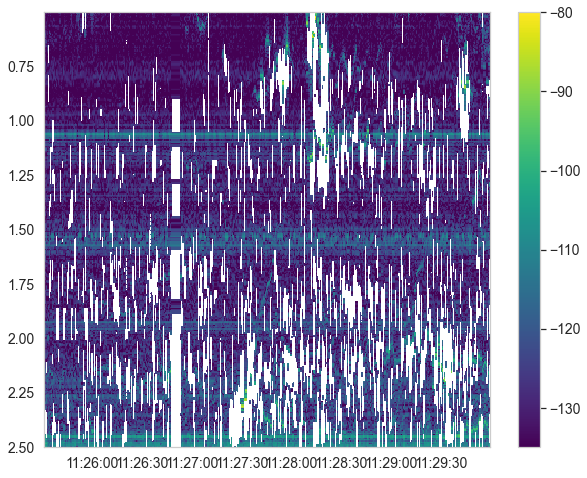

In [19]:
plt.figure(figsize=(10,8))
plt.pcolormesh(times,np.linspace(start_range, end_range,n_bins-1),TS_data_thres.T, cmap="viridis")
plt.clim([-135,-80])
plt.gca().invert_yaxis()
plt.colorbar()

### Project to range axis only (median across time) and smooth
use a 0.1 m depth filter

In [9]:
N = 18  #0.1m/d_range

conv_TS = np.convolve(np.nanmedian(TS_data_thres,0), np.ones(N)/N, mode='full')
smooth_TS = conv_TS[N:-N]

In [20]:
# Boxcar running mean
depth_range = np.linspace(start_range, end_range,n_bins-1)
edge = int(N/2)
depth_smooth = depth_range[edge:-edge-1]

### Plot noise profile with  range limits indicated

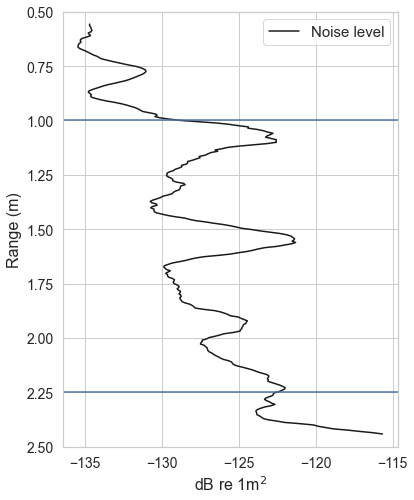

In [18]:
plt.figure(figsize=(6,8))
plt.plot(smooth_TS, depth_smooth, 'k-', label='Noise level')
plt.axhline(1)
plt.axhline(2.25)
plt.ylim([0.5,2.5])
plt.xlabel('dB re 1m$^2$')
plt.ylabel('Range (m)')
plt.legend(fontsize=15)
plt.gca().invert_yaxis()

### Export to file 

In [12]:
noise_df = pd.DataFrame({'range':depth_smooth,'TS':smooth_TS})
noise_df = noise_df.reset_index()

In [13]:
noise_df.to_feather('Noise_AZKABAN_200kHz.feather')

# Plot
Plot the noise level and the echogram side-by-side

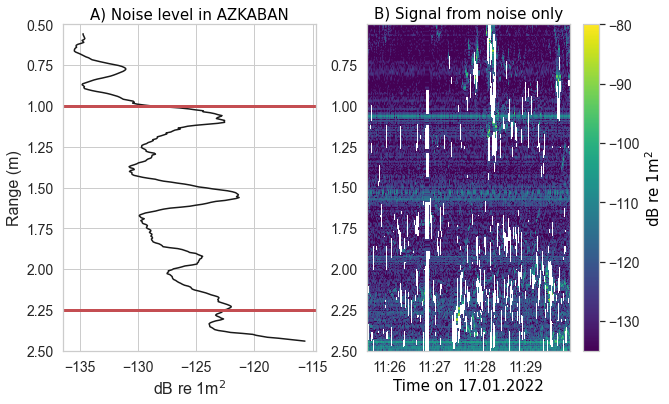

In [17]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(smooth_TS, depth_smooth, 'k-', label='Noise level')
plt.axhline(y=1, c='r', linewidth=3)
plt.axhline(y=2.25, c='r', linewidth=3)
plt.ylim([0.5,2.5])
plt.xlabel('dB re 1m$^2$')
plt.ylabel('Range (m)')
#plt.legend(fontsize=15)
plt.title('A) Noise level in AZKABAN', title_font)
plt.gca().invert_yaxis()

ax = plt.subplot(1,2,2)
plt.pcolormesh(times,np.linspace(start_range, end_range,n_bins-1),TS_data_thres.T, cmap="viridis")
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xlabel('Time on 17.01.2022', axis_font)
plt.clim([-135,-80])
plt.gca().invert_yaxis()
plt.title('B) Signal from noise only', title_font)
cbar = plt.colorbar()
cbar.ax.set_ylabel('dB re 1m$^2$', axis_font);
